In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from dfply import *
from tableone import TableOne

### Data Exploration and Prep

In [2]:
# reading in family info and subsetting to 65+ year olds
peeps = pd.read_csv('Data/personsx.csv')
peeps = peeps.assign(_id=np.arange(len(peeps))).reset_index(drop=True)
peeps65 = peeps[(peeps['AGE_P']>=65)].copy()
peeps65.shape

(13389, 602)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021988D78E48>,
      dtype=object)

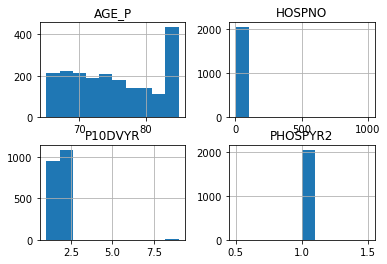

In [3]:
peeps65[['AGE_P', 'P10DVYR', 'PHOSPYR2', 'HOSPNO']].dropna().hist(sharex=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021988D78AC8>,
      dtype=object)

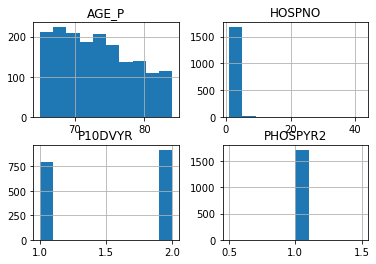

In [4]:
# 999, [7,8,9], 6, 85, a lot of useless responses relating to not ascertained or unknown or respondent doesn't know
# consulted codebook
def remove_useless_responses(df, col, values):
    df[col] = np.where(df[col].isin(values), np.nan, df[col])
    
remove_useless_responses(peeps65, 'HOSPNO', [999])
remove_useless_responses(peeps65, 'AGE_P', [85])
remove_useless_responses(peeps65, 'P10DVYR', [7,8,9])
remove_useless_responses(peeps65, 'PHOSPYR2', [7,8,9])
remove_useless_responses(peeps65, 'WRKLYR1', [7,8,9])
remove_useless_responses(peeps65, 'COVER65', [6])

peeps65[['AGE_P', 'P10DVYR', 'PHOSPYR2', 'HOSPNO']].dropna().hist()

In [5]:
# histogram was usless
peeps65['PHOSPYR2'].value_counts() 

2.0    11320
1.0     2049
Name: PHOSPYR2, dtype: int64

In [6]:
# more information in hospital nights
peeps65['HOSPNO'].describe()

count    2041.000000
mean        1.582068
std         1.620413
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        42.000000
Name: HOSPNO, dtype: float64

In [7]:
# probably want to categorize
peeps65['HOSPNO'].value_counts()

1.0     1429
2.0      369
3.0      128
4.0       57
5.0       21
6.0       16
9.0        6
7.0        5
10.0       4
14.0       2
30.0       1
42.0       1
12.0       1
8.0        1
Name: HOSPNO, dtype: int64

In [8]:
# recoding a few things
# work last year
peeps65['WRK_LST_YR'] = ''
peeps65['WRK_LST_YR'] = np.where(peeps65['WRKLYR1'] == 1, 'Yes', peeps65['WRK_LST_YR'])
peeps65['WRK_LST_YR'] = np.where(peeps65['WRKLYR1'] == 2, 'No', peeps65['WRK_LST_YR'])
peeps65['WRK_LST_YR'] = np.where(peeps65['WRK_LST_YR'] == '', np.nan, peeps65['WRK_LST_YR'])

# insurance 
peeps65['INSURANCE'] = ''
peeps65['INSURANCE'] = np.where(peeps65['COVER65'] == 1, 'Private', peeps65['INSURANCE'])
peeps65['INSURANCE'] = np.where(peeps65['COVER65'] == 2, 'Dual eligible', peeps65['INSURANCE'])
peeps65['INSURANCE'] = np.where(peeps65['COVER65'] == 3, 'Medicare Advantage', peeps65['INSURANCE'])
peeps65['INSURANCE'] = np.where(peeps65['COVER65'] == 4, 'Medicare only', peeps65['INSURANCE'])
peeps65['INSURANCE'] = np.where(peeps65['COVER65'] == 5, 'Other coverage', peeps65['INSURANCE'])
peeps65['INSURANCE'] = np.where(peeps65['INSURANCE'] == '', np.nan, peeps65['INSURANCE'])

# limited
peeps65['LIMITED'] = ''
peeps65['LIMITED'] = np.where(peeps65['LACHRONR'] == 0, 'Not limited in anyway', peeps65['LIMITED'])
peeps65['LIMITED'] = np.where(peeps65['LACHRONR'] == 1, 'Limited; chronic condition', peeps65['LIMITED'])
peeps65['LIMITED'] = np.where(peeps65['LACHRONR'].isin([2,3]), 'Limited; not chronic or status unknown', peeps65['LIMITED'])
peeps65['LIMITED'] = np.where(peeps65['LIMITED'] == '', np.nan, peeps65['LIMITED'])

# 10 primary care visits in the last year.... this seems like a lot
peeps65['VISITS_10'] = ''
peeps65['VISITS_10'] = np.where(peeps65['P10DVYR'] == 1, 'Yes', peeps65['VISITS_10'])
peeps65['VISITS_10'] = np.where(peeps65['P10DVYR'] == 2, 'No', peeps65['VISITS_10'])
peeps65['VISITS_10'] = np.where(peeps65['VISITS_10'] == '', np.nan, peeps65['VISITS_10'])

# Assuming an overnight hospital stay is an admission
peeps65['HOSPITAL_STAY'] = ''
peeps65['HOSPITAL_STAY'] = np.where(peeps65['PHOSPYR2'] == 1, 'Yes', peeps65['HOSPITAL_STAY'])
peeps65['HOSPITAL_STAY'] = np.where(peeps65['PHOSPYR2'] == 2, 'No', peeps65['HOSPITAL_STAY'])
peeps65['HOSPITAL_STAY'] = np.where(peeps65['HOSPITAL_STAY'] == '', np.nan, peeps65['HOSPITAL_STAY'])

# categorizing overnight stays
peeps65['HOSPNO_CAT'] = ''
peeps65['HOSPNO_CAT'] = np.where(peeps65['HOSPNO'] == 1, '1', peeps65['HOSPNO_CAT'])
peeps65['HOSPNO_CAT'] = np.where(peeps65['HOSPNO'] == 2, '2', peeps65['HOSPNO_CAT'])
peeps65['HOSPNO_CAT'] = np.where(peeps65['HOSPNO'] == 3, '3', peeps65['HOSPNO_CAT'])
peeps65['HOSPNO_CAT'] = np.where(peeps65['HOSPNO'] > 3, '4 or more', peeps65['HOSPNO_CAT'])
peeps65['HOSPNO_CAT'].value_counts()

             11348
1             1429
2              369
3              128
4 or more      115
Name: HOSPNO_CAT, dtype: int64

In [9]:
peeps65.INSURANCE.value_counts()

Private               5608
Medicare Advantage    3389
Medicare only         2345
Other coverage         966
Dual eligible          923
Name: INSURANCE, dtype: int64

### Are individuals who have 10 or more visits during the calendar year more likely to also have a hospital stay?
- Are they continually having problems?
- Are they abusing the healthcare system?
- Are they extremely proactive about their health?

In [10]:
cols_to_keep = ['_id','HOSPITAL_STAY', 'HOSPNO_CAT', 'VISITS_10', 'AGE_P', 'LIMITED', 'INSURANCE', 'WRK_LST_YR']
dat = peeps65[cols_to_keep].copy().dropna()
dat.shape

(11721, 8)

In [11]:
columns = ['VISITS_10', 'AGE_P', 'LIMITED', 'INSURANCE', 'WRK_LST_YR', 'HOSPITAL_STAY']
categorical = ['VISITS_10', 'LIMITED', 'INSURANCE', 'WRK_LST_YR', 'HOSPITAL_STAY']
groupby = ['VISITS_10']
# nonnormal = columns[1:len(columns)]
# mytable = TableOne(baseProv, columns, categorical, groupby, nonnormal, pval=True, isnull=True)
mytable = TableOne(dat, columns, categorical, groupby, pval=True)
# mytable.to_excel('tableone.xlsx')
mytable

D:\Miniconda3\lib\site-packages\numpy\lib\nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
D:\Miniconda3\lib\site-packages\numpy\lib\nanfunctions.py:1367: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
D:\Miniconda3\lib\site-packages\tableone.py:468: RuntimeWarning: Mean of empty slice
  return f.format(np.nanmean(x.values),


Grouped by VISITS_10                                                       
                                                                  Missing            No           Yes P-Value               Test
n                                                                                  9575          2146                           
VISITS_10     No                                                        0  9575 (100.0)                <0.001        Chi-squared
              Yes                                                                        2146 (100.0)                           
AGE_P                                                                   0    72.1 (5.4)    72.8 (5.5)  <0.001  Two Sample T-test
LIMITED       Limited; chronic condition                                0   2162 (22.6)   1254 (58.4)  <0.001        Chi-squared
              Limited; not chronic or status unknown                           62 (0.6)      19 (0.9)                           
              Not limited in anyway                                         7351 (76.8)    873 (40.7)                           
INSURANCE     Dual eligible                                             0     512 (5.3)    295 (13.7)  <0.001        Chi-squared
              Medicare Advantage                                            2563 (26.8)    478 (22.3)                           
              Medicare only                                                 1773 (18.5)    303 (14.1)                           
              Other coverage                                                  677 (7.1)     170 (7.9)                           
              Private                                                       4050 (42.3)    900 (41.9)                           
WRK_LST_YR    No                                                        0   6994 (73.0)   1781 (83.0)  <0.001        Chi-squared
              Yes                                                           2581 (27.0)    365 (17.0)                           
HOSPITAL_STAY No                                                        0   8661 (90.5)   1350 (62.9)  <0.001        Chi-squared
              Yes                                                             914 (9.5)    796 (37.1)                           
[1] Warning, Hartigan's Dip Test reports possible multimodal distributions for: AGE_P.
[2] Warning, test for normality reports non-normal distributions for: AGE_P.

In [12]:
# quick crosstab
tab = pd.crosstab(dat['VISITS_10'],dat['HOSPITAL_STAY'])
tab

HOSPITAL_STAY,No,Yes
VISITS_10,,
No,8661,914
Yes,1350,796


[(0, 40),
 Text(0, 0.5, 'Percent with hospitalization in last year'),
 Text(0.5, 0, '>= 10 healthcare visits in last year')]

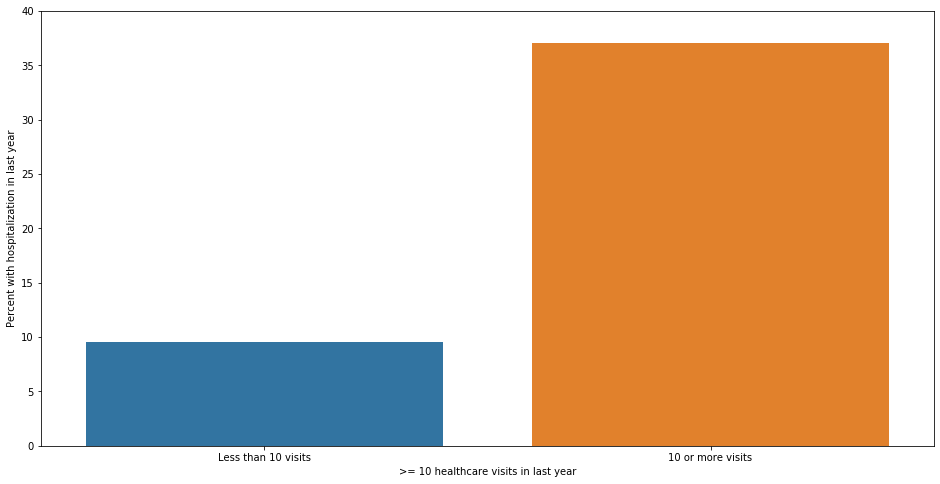

In [13]:
# Further analysis of this question regarding 10 visits and likelihood of hospital stay
plt.figure(figsize=(16, 8))
pctdf = (dat >>
         mutate(COUNT = 1) >>
         group_by(X.VISITS_10, X.HOSPITAL_STAY) >>
         summarize(N = n(X.COUNT)) >>
         spread(X.HOSPITAL_STAY, X.N)
         )
pctdf.columns = ['VISITS_10', 'NO_HOSP', 'HOSP']
pctdf['PERCENT'] = round((pctdf['HOSP'] / (pctdf['NO_HOSP'] + pctdf['HOSP']))*100,2)
pctdf['VISITS_10_LAB'] = np.where(pctdf['VISITS_10'] == 'Yes', '10 or more visits', 'Less than 10 visits')
bp = sns.barplot(x = 'VISITS_10_LAB', y = 'PERCENT', data = pctdf)
bp.set(xlabel='>= 10 healthcare visits in last year', ylabel='Percent with hospitalization in last year', ylim=(0, 40))

### Among those with a hospitalization... are those with 10 or more visits more frequent users of the hospital?

In [14]:
# Further analysis on this question
dat2 = dat[dat['HOSPITAL_STAY']=='Yes'].copy()
dat2.shape

(1710, 8)

In [15]:
tab = pd.crosstab(dat['HOSPNO_CAT'],dat['VISITS_10'])
dat['HOSPNO_CAT'].value_counts()

             10016
1             1195
2              306
3              109
4 or more       95
Name: HOSPNO_CAT, dtype: int64

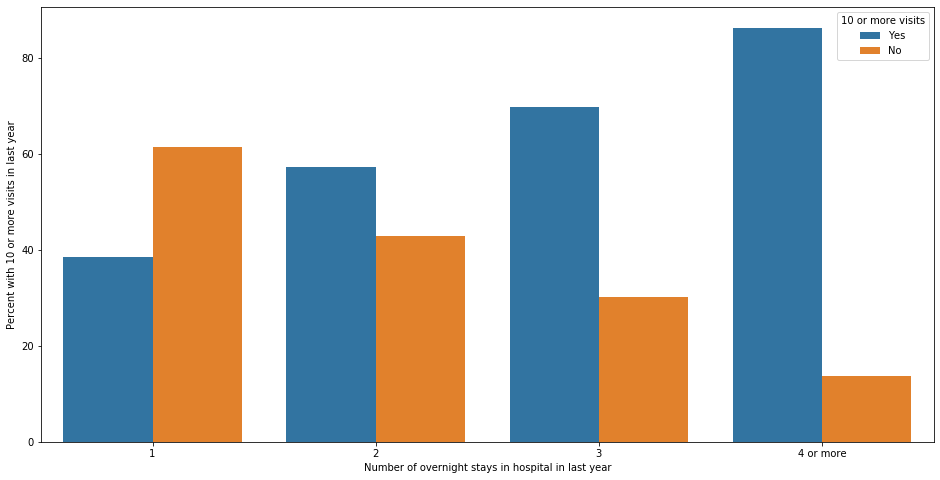

In [16]:
plt.figure(figsize=(16, 8))
pctdf = (dat >>
         mutate(COUNT = 1) >>
         group_by(X.VISITS_10, X.HOSPNO_CAT) >>
         summarize(N = n(X.COUNT)) >>
         spread(X.VISITS_10, X.N) >>
         mask(X.HOSPNO_CAT != '')
         )
pctdf.columns = ['HOSPNO_CAT', 'VISITS_10_NO', 'VISITS_10_YES']
pctdf['PERCENT_NO'] = round((pctdf['VISITS_10_NO'] / (pctdf['VISITS_10_NO'] + pctdf['VISITS_10_YES']))*100,2)
pctdf['PERCENT_YES'] = round((pctdf['VISITS_10_YES'] / (pctdf['VISITS_10_NO'] + pctdf['VISITS_10_YES']))*100,2)

# not the cleanest way to do it, but whatever
dfno = pctdf[['HOSPNO_CAT','PERCENT_NO']].copy()
dfno.columns = ['HOSPNO_CAT', 'PERCENT']
dfno['VISITS_10'] = 'No'

dfyes = pctdf[['HOSPNO_CAT','PERCENT_YES']].copy()
dfyes.columns = ['HOSPNO_CAT', 'PERCENT']
dfyes['VISITS_10'] = 'Yes'

pctdf = pd.concat([dfyes, dfno], axis = 0).reset_index(drop = True)

bp = sns.barplot(x = 'HOSPNO_CAT', y = 'PERCENT', hue = 'VISITS_10', data = pctdf)
bp.set(xlabel='Number of overnight stays in hospital in last year', ylabel='Percent with 10 or more visits in last year')
plt.legend(title='10 or more visits')

In [17]:
# Statistical modeling if time alots 
# SURPRISE. It didn't.